(01-nonlinear-decision-boundary)=
# Nonlinear decision boundary

Going back to classification. Let us generate data that is not linearly separable. 
In this section, we will show that linear classification extends to input data that is not linearly separable. The idea is to apply a sequence of transformations (nonlinear, i.e. using activations) on the input $\boldsymbol{\mathsf{x}}$ such that the final features $f(\boldsymbol{\mathsf{x}})$ become linearly separable.

In [1]:
import torch 
torch.manual_seed(2)

N = 1500  # sample size
noise = lambda e: torch.randn(N, 2) * e
t = 2 * torch.pi * torch.rand(N, 1)
s = 2 * torch.pi * torch.rand(N, 1)

x0 = torch.cat([0.1 * torch.cos(s), 0.1 * torch.sin(s)], dim=1) + noise(0.05)
x1 = torch.cat([1.0 * torch.cos(t), 1.0 * torch.sin(t)], dim=1) + noise(0.1)
y0 = (torch.ones(N,) * 0).long()
y1 = (torch.ones(N,) * 1).long()

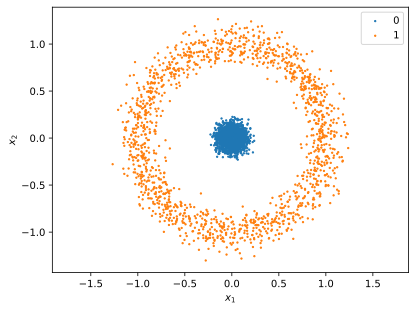

In [2]:
%config InlineBackend.figure_format = 'svg'
import matplotlib.pyplot as plt

plt.scatter(x0[:, 0], x0[:, 1], s=2.0, label=0, color="C0")
plt.scatter(x1[:, 0], x1[:, 1], s=2.0, label=1, color="C1")
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.legend()
plt.axis('equal');

Modeling this with a fully-connected neural network with one hidden layer containing units that uses the [tanh function](https://mathworld.wolfram.com/HyperbolicTangent.html) as activation: $\text{tanh}(z) = \frac{e^{z} - e^{-z}}{e^{z} + e^{-z}}.$
This maps $\mathbb{R}$ to $[-1, 1]$ symmetrically with $\text{tanh}(0) = 0$ and $\text{tanh}(z) \to \pm 1$ as $z \to \pm\infty.$ Note that tanh is actually just a scaled and translated version of the sigmoid function.

In [3]:
import torch.nn as nn
from torchsummary import summary

model = lambda: nn.Sequential(
    nn.Linear(2, 3), nn.Tanh(),
    nn.Linear(3, 2)
)

summary(model(), input_size=(2,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                    [-1, 3]               9
              Tanh-2                    [-1, 3]               0
            Linear-3                    [-1, 2]               8
Total params: 17
Trainable params: 17
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


Gradient descent on [**cross-entropy loss**](https://en.wikipedia.org/wiki/Cross-entropy) (equivalent to NLL):

In [4]:
import torch.nn.functional as F

net = model()
optim = torch.optim.SGD(net.parameters(), lr=0.01)

x = torch.cat([x0, x1])
y = torch.cat([y0, y1])
history = {"accs": [], "loss": []}
for step in range(25000):
    s = net(x)
    loss = F.cross_entropy(s, y)
    loss.backward()
    optim.step()
    optim.zero_grad()
    history["loss"].append(loss.item())
    history["accs"].append(100 * (y == torch.argmax(s, dim=1)).float().mean())

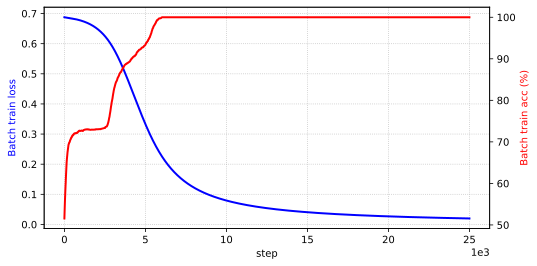

In [12]:
fig, ax1 = plt.subplots(figsize=(8, 4))

ax1.plot(history["loss"], color="blue", linewidth=2)
ax1.set_xlabel("step")
ax1.ticklabel_format(axis="x", style="sci", scilimits=(3, 3))
ax1.grid(axis="both", linestyle="dotted", alpha=0.8)

ax2 = ax1.twinx()
ax2.plot(history["accs"], color="red", linewidth=2)

ax1.set_ylabel("Batch train loss")
ax2.set_ylabel("Batch train acc (%)")
ax1.yaxis.label.set_color("blue")
ax2.yaxis.label.set_color("red");

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# transformations
with torch.no_grad():
    linear_0 = net[0](x0)
    linear_1 = net[0](x1)
    linear_act_0 = net[1](net[0](x0))
    linear_act_1 = net[1](net[0](x1))

    # separating hyperplane (see above discussion, i.e. w <- w1 - w0  == logistic reg)
    h = 1
    w, b = net[2].parameters()
    w, b = (w[h] - w[h-1]), (b[h] - b[h-1])

# plot
fig = plt.figure(figsize=(12, 4))
ax0 = fig.add_subplot(131)
ax1 = fig.add_subplot(132, projection='3d')
ax2 = fig.add_subplot(133, projection='3d')

ax0.grid(alpha=0.8, linestyle="dotted")
ax0.set_axisbelow(True)
ax0.scatter(x0[:, 0], x0[:, 1], s=2.0, label=0, color="C0")
ax0.scatter(x1[:, 0], x1[:, 1], s=2.0, label=1, color="C1")
ax0.set_xlabel("$x_1$")
ax0.set_ylabel("$x_2$")
ax0.set_xlim(-1.5, 1.5)
ax0.set_ylim(-1.5, 1.5)
ax0.set_title("(a) input")
ax0.legend()
ax0.axis('equal')

ax1.scatter(linear_0[:, 0], linear_0[:, 1], linear_0[:, 2], s=3, label=0, color="C0")
ax1.scatter(linear_1[:, 0], linear_1[:, 1], linear_1[:, 2], s=3, label=1, color="C1")
ax1.set_xlabel('$x_1$')
ax1.set_ylabel('$x_2$')
ax1.set_zlabel('$x_3$')
ax1.set_title('(b) linear')

ax2.scatter(linear_act_0[:, 0], linear_act_0[:, 1], linear_act_0[:, 2], s=3, label=0, color="C0")
ax2.scatter(linear_act_1[:, 0], linear_act_1[:, 1], linear_act_1[:, 2], s=3, label=1, color="C1")
ax2.set_xlabel('$x_1$')
ax2.set_ylabel('$x_2$')
ax2.set_zlabel('$x_3$')
ax2.set_title('(c) linear + tanh')

# Generate grid of points
x_min = min(linear_act_1[:, 0].min(), linear_act_0[:, 0].min())
x_max = max(linear_act_1[:, 0].max(), linear_act_0[:, 0].max())
y_min = min(linear_act_1[:, 1].min(), linear_act_0[:, 1].min())
y_max = max(linear_act_1[:, 1].max(), linear_act_0[:, 1].max())
a, b, c, d = w[0], w[1], w[2], b
x = np.linspace(x_min, x_max, 50)
y = np.linspace(y_min, y_max, 50)
X, Y = np.meshgrid(x, y)
Z = (-a * X - b * Y - d) / c

# Plot the hyperplane for the positive class
ax2.plot_surface(X, Y, Z, alpha=0.5, color=f"C{h}")
fig.tight_layout();

**Remark.** In general, a weight vector is learned for each class, so that there are as many separating hyperplanes as the number of classes. 
For binary classification with softmax, the weight vectors and biases fuse resulting in one separating plane.

Checking classification accuracy:

In [7]:
a = (torch.argmax(net(x0), dim=1) == y0).float().mean().item()
b = (torch.argmax(net(x1), dim=1) == y1).float().mean().item()
a, b

(1.0, 1.0)

Decision boundary in the input space. Note that we have to convert logits to probabilities:

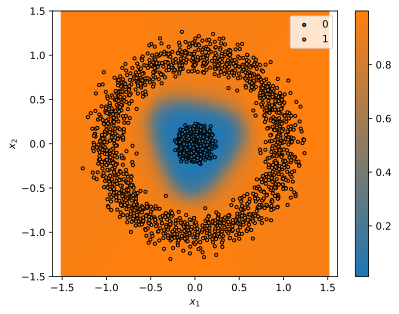

In [8]:
from matplotlib.colors import LinearSegmentedColormap

# define custom colormap
colors = ["C0", "C1"]
n_bins = 100
cm = LinearSegmentedColormap.from_list(name="", colors=colors, N=n_bins)

# create a grid of points
N = 100
x = np.linspace(-1.5, 1.5, N)
y = np.linspace(-1.5, 1.5, N)
X, Y = np.meshgrid(x, y)

# calculate p1 for each point in grid
Z = np.zeros_like(X)
for i in range(N):
    for j in range(N):
        out = F.softmax(net(torch.tensor([[float(X[i, j]), float(Y[i, j])]])), dim=1)
        Z[i, j] = out[0][1]

# create a color plot
plt.pcolormesh(X, Y, Z, shading="auto", cmap=cm, rasterized=True)
plt.colorbar()
plt.xlabel("X")
plt.ylabel("Y")

plt.scatter(x0[:, 0], x0[:, 1], s=10.0, label=0, color="C0", edgecolor="black")
plt.scatter(x1[:, 0], x1[:, 1], s=10.0, label=1, color="C1", edgecolor="black")
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.legend()
plt.axis("equal");

plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)
plt.show();

Fig. *Probability assigned by the trained network on the input space. Note that we were able to extend linear classification to learning a nonlinear decision boundary. Using ReLU activation here instead of Tanh results in a boundary with sharp corners. This can be thought of as a manifestation of inductive bias.*